# Work pipeline of Task 4 & Task 5
## Kaggle Submission score: 0.0650391 (v.1), 0.0650219 (v.2)

 This file is divided into 3 phases
    - Data cleaning
    - Training and Testing with a few models
    - Using the entire Properties dataset to 
    make a prediction and submission to Kaggle

In [556]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import datasets, linear_model
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [557]:
## Read the Key, logerror, transaction date set
df_parcel = pd.read_csv("c:/Users/ibipul/Documents/Python Scripts/datasets/zillow_data/train_2016_v2.csv")

In [558]:
## Read the attribute set
df_properties = pd.read_csv("c:/Users/ibipul/Documents/Python Scripts/datasets/zillow_data/properties_2016.csv",low_memory=False)

## Variable Selection and Data cleanup 
    - In this stage we use the selected variables and re-format and clean the data up for subsequent modelling.
    - First the two data tables are joined & relevant variables are selected.
    - After this Numeric and Categorical variables (which are numeric labels) are treated separately.
        -For Numeric variables we impute missing variables with Median values of the column. 
        They are alseo normalised using the mean and standard deviation of the columns.
        -For Categorical variables are 0 imputed as a new category of 'no-info' and then one hot encoded
    - Finally The data is split into a 75-25 Train test split and model building takes place.

In [560]:
# Categorical variables are Numeric here. Replace NaN's with 0.0, then hot one encode.
categorical_variables=['airconditioningtypeid','buildingqualitytypeid','heatingorsystemtypeid']

## Impute the NaN's in the following columns with median values
numeric_variables = ['bathroomcnt','bedroomcnt','roomcnt','fullbathcnt', 'calculatedbathnbr',
          'calculatedfinishedsquarefeet', 'finishedsquarefeet12','garagetotalsqft',
          'structuretaxvaluedollarcnt','taxvaluedollarcnt', 'landtaxvaluedollarcnt']

# This is the key variable that will help with the join
key_variable = ['parcelid']

# Full variable list:
properties_variables = key_variable + numeric_variables + categorical_variables

In [561]:
## Sub setting the properties variables
df = df_properties[properties_variables]

In [562]:
## Merging the id,logerr,transaction data set with the above
dfmain = pd.merge(df_parcel,df,on='parcelid')

In [563]:
# date parser
def get_month(transaction_date):
    s=transaction_date.split('-')
    month=int(s[1])
    return month

# Adding a new column as month of transaction
dfmain['month'] = dfmain['transactiondate'].apply(lambda x: get_month(x))

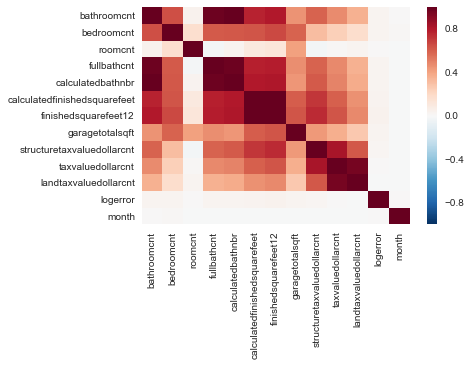

In [564]:
df_corr = dfmain[numeric_variables + ['logerror', 'month']]
sns.heatmap(df_corr.corr(), xticklabels=df_corr.columns.values,yticklabels=df_corr.columns.values)

In [565]:
dfmain.shape

(90275, 18)

In [567]:
#Checking for missing data in numeric variables
#for i in numeric_variables:
#    print(i, sum(dfmain[i].notnull()*1))

In [568]:
#Creating an imputation dictionary
imputation_dict = defaultdict()
for i in numeric_variables:
    x = sum(dfmain[i].notnull()*1)
    imputation_dict[i]=dfmain[i].median()

In [569]:
imputation_dict

defaultdict(None,
            {'bathroomcnt': 2.0,
             'bedroomcnt': 3.0,
             'calculatedbathnbr': 2.0,
             'calculatedfinishedsquarefeet': 1540.0,
             'finishedsquarefeet12': 1518.0,
             'fullbathcnt': 2.0,
             'garagetotalsqft': 433.0,
             'landtaxvaluedollarcnt': 192970.0,
             'roomcnt': 0.0,
             'structuretaxvaluedollarcnt': 132000.0,
             'taxvaluedollarcnt': 342872.0})

In [570]:
# Imputing missing data with median values of columns
for i in numeric_variables:
    x = sum(dfmain[i].isnull()*1)
    if x>0:
        dfmain[i].replace(np.nan,imputation_dict[i],inplace=True)
        print("imputation happened for: ", i," with ",imputation_dict[i])

imputation happened for:  fullbathcnt  with  2.0
imputation happened for:  calculatedbathnbr  with  2.0
imputation happened for:  calculatedfinishedsquarefeet  with  1540.0
imputation happened for:  finishedsquarefeet12  with  1518.0
imputation happened for:  garagetotalsqft  with  433.0
imputation happened for:  structuretaxvaluedollarcnt  with  132000.0
imputation happened for:  taxvaluedollarcnt  with  342872.0
imputation happened for:  landtaxvaluedollarcnt  with  192970.0


In [571]:
#Normalizing The Numeric variables
# Creating dictionaries for mu and sigma
#Creating an imputation dictionary
mu_dict = defaultdict()
sig_dict = defaultdict()
for i in numeric_variables:
    mu_dict[i] = dfmain[i].mean()
    sig_dict[i] = dfmain[i].std()
    dfmain[i]=(dfmain[i]-mu_dict[i])/sig_dict[i]
    
# Hence we store the Mu and Std dev dictionary from the training phase

In [572]:
dfmain.head()

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,roomcnt,fullbathcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,garagetotalsqft,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,airconditioningtypeid,buildingqualitytypeid,heatingorsystemtypeid,month
0,11016594,0.0276,2016-01-01,-0.278285,-0.027558,-0.524366,-0.248716,-0.314477,-0.094574,-0.055962,0.182241,-0.273759,-0.175716,-0.102170,1.0,4.0,2.0,1
1,14366692,-0.1684,2016-01-01,1.215335,0.837168,-0.524366,0.795989,1.231281,0.531391,0.596447,0.402113,0.798069,0.230423,-0.098038,NaN,NaN,NaN,1
2,12098116,-0.0040,2016-01-01,0.717462,-0.892284,-0.524366,0.795989,0.716029,0.481659,0.544615,0.182241,-0.564877,-0.608716,-0.550377,1.0,4.0,2.0,1
3,12643413,0.0218,2016-01-02,-0.278285,-0.892284,-0.524366,-0.248716,-0.314477,-1.008116,-1.008097,0.182241,-0.040117,-0.383490,-0.511800,1.0,4.0,2.0,1
4,14432541,-0.0050,2016-01-02,0.219588,0.837168,2.312889,-0.248716,0.200776,0.553013,0.618983,1.218781,-0.049431,-0.041667,-0.033352,NaN,NaN,NaN,1


In [573]:
# Checking for NaNs in categorical numeric variables
for i in categorical_variables:
    print(i, sum(dfmain[i].notnull()*1))

airconditioningtypeid 28781
buildingqualitytypeid 57364
heatingorsystemtypeid 56080


In [574]:
categorical_variables

['airconditioningtypeid', 'buildingqualitytypeid', 'heatingorsystemtypeid']

In [575]:
## Replacing NaNs in Categorical variables with 0's
for i in categorical_variables:
    dfmain[i].replace(np.nan,0.0,inplace=True)

In [576]:
# Checking for NaNs in categorical numeric variables
for i in categorical_variables:
    print(i, sum(dfmain[i].notnull()*1))

airconditioningtypeid 90275
buildingqualitytypeid 90275
heatingorsystemtypeid 90275


In [577]:
# Month is also a categorical variable so it should be one-hot encoded
categorical_variables.append('month')

In [578]:
## One hot encoding the categorical variables
columnsToEncode = categorical_variables
# Adding dummies
for feature in columnsToEncode:
        print('One Hot Encoding: ', feature)
        dfmain = pd.concat([dfmain, pd.get_dummies(dfmain[feature],prefix=feature)], axis=1)
        del dfmain[feature]


One Hot Encoding:  airconditioningtypeid
One Hot Encoding:  buildingqualitytypeid
One Hot Encoding:  heatingorsystemtypeid
One Hot Encoding:  month


In [579]:
dfmain.head()

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,roomcnt,fullbathcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,11016594,0.0276,2016-01-01,-0.278285,-0.027558,-0.524366,-0.248716,-0.314477,-0.094574,-0.055962,...,0,0,0,0,0,0,0,0,0,0
1,14366692,-0.1684,2016-01-01,1.215335,0.837168,-0.524366,0.795989,1.231281,0.531391,0.596447,...,0,0,0,0,0,0,0,0,0,0
2,12098116,-0.0040,2016-01-01,0.717462,-0.892284,-0.524366,0.795989,0.716029,0.481659,0.544615,...,0,0,0,0,0,0,0,0,0,0
3,12643413,0.0218,2016-01-02,-0.278285,-0.892284,-0.524366,-0.248716,-0.314477,-1.008116,-1.008097,...,0,0,0,0,0,0,0,0,0,0
4,14432541,-0.0050,2016-01-02,0.219588,0.837168,2.312889,-0.248716,0.200776,0.553013,0.618983,...,0,0,0,0,0,0,0,0,0,0


In [554]:
#dfmain.columns

In [580]:
## Creating a test-train split
train=dfmain.sample(frac=0.75,random_state=200)
test=dfmain.drop(train.index)

In [581]:
train.head()

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,roomcnt,fullbathcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
33534,12298892,-0.0070,2016-05-10,-1.274032,-0.892284,-0.524366,-1.293420,-1.344982,-0.676214,-0.662174,...,0,0,1,0,0,0,0,0,0,0
74398,12546271,-0.1791,2016-09-09,1.713209,2.566620,-0.524366,1.840694,1.746534,2.139007,-0.243009,...,0,0,0,0,0,0,1,0,0,0
18216,14465356,0.0020,2016-03-22,0.219588,0.837168,2.667546,-0.248716,0.200776,1.323847,1.422382,...,1,0,0,0,0,0,0,0,0,0
72001,12069190,-0.0090,2016-08-31,0.717462,-0.892284,-0.524366,0.795989,0.716029,-0.478370,-0.455972,...,0,0,0,0,0,1,0,0,0,0
77568,11115649,-0.0222,2016-09-20,0.717462,-0.027558,-0.524366,0.795989,0.716029,-0.477289,-0.454845,...,0,0,0,0,0,0,1,0,0,0


In [582]:
# Separating predictors and response variables
all_column_names = list(train.columns)
for i in ['parcelid','logerror','transactiondate']:
    all_column_names.remove(i)
    
# X variable names
x_vars = all_column_names
y_var = 'logerror'
# Train set
train_Y = train[y_var]
train_X = train[x_vars]
#Test set
test_Y = test[y_var]
test_X = test[x_vars]
test_key = test['parcelid']

## Model building phase
 - I will start with logistic regression from previous exercise and then move to other models
 - KNN and Random Forest regressors are some model I would be exploring.

In [583]:
#Create a Linear regression model
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(train_X, train_Y)
# Make predictions using the testing set
logerror_prediction_y = regr.predict(test_X)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %1.5f"
      % mean_squared_error(test_Y, logerror_prediction_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %1.5f' % r2_score(test_Y, logerror_prediction_y))

Coefficients: 
 [ -1.41865482e-02   6.92479507e-04   1.84469761e-04   3.04091749e-04
   1.25690110e-02   3.05018204e-03   4.85548312e-03  -1.10087931e-03
  -1.21592114e-01   3.27223464e-01  -2.40022999e-01  -1.64715262e-02
  -1.82725785e-02   8.82484739e-02  -2.03416103e-02  -1.36327918e-02
  -3.68636791e-03  -1.58435992e-02  -7.16057909e-02  -7.84168290e-02
  -7.40271105e-02  -2.56984519e-02  -7.41110776e-02   6.16700154e-01
  -7.90314220e-02  -9.64500601e-02  -1.17359412e-01   6.11361890e-03
   2.14253703e-02   1.16603420e-02   7.34158972e-03   8.75107124e-03
  -3.33721220e-02  -2.82958033e-02  -7.71607579e-03  -8.74794191e-03
   2.86539793e-02   1.61494248e-02  -4.27822233e-03  -1.76852309e-02
   2.05822416e-03   4.79686878e-03  -2.53566564e-03  -7.65736334e-03
  -5.32513359e-03  -6.36650942e-03  -2.09441461e-03  -1.12054578e-03
   4.18818171e-03   4.79841312e-03   3.15305931e-03   6.10488531e-03]
Mean squared error: 0.02667
Variance score: 0.00046


In [590]:
#Create a K-Nearest Neighbour model
knn = neighbors.KNeighborsRegressor(n_neighbors=90,weights='distance')
# Train the model using the training sets & Make predictions using the testing set
logerror_prediction_y = knn.fit(train_X, train_Y).predict(test_X)
# The mean squared error
print("Mean squared error: %1.5f"
      % mean_squared_error(test_Y, logerror_prediction_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %1.5f' % r2_score(test_Y, logerror_prediction_y))

Mean squared error: 0.02681
Variance score: -0.00482


In [598]:
# Random forest example
randreg = RandomForestRegressor(n_estimators=40,max_depth=4,warm_start=True)
randreg.fit(train_X,train_Y)
logerror_prediction_y=randreg.predict(test_X)
# The mean squared error
print("Mean squared error: %1.5f"
      % mean_squared_error(test_Y, logerror_prediction_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %1.5f' % r2_score(test_Y, logerror_prediction_y))

Mean squared error: 0.02642
Variance score: 0.00963


### Summary of model exploration
So models I tested with are Linear regression, Knearest neighbour regression and Random forest. In each case the RMSE was around 0.03. However, with some tuning of the model parameters, and cleaning of variables-- R^2 value changed. Random Forest regressors with 40 estimators, and maximum tree-depth or 4 seems to be working well as per the data I have. R^2 Value was approximately 0.01 (which is much better than 0.0005 for the linear regression). So to summarize:

    - Linear regression: RMSE: 0.0267, R^2: 0.00046
    - K Nearest Neighbour: RMSE: 0.0274, R^2: -0.005 (improved from -0.17, by tuning the n_neighbours parameter)
    - Random Forest regressor: RMSE 0.026, R^2: 0.009 (improved from -0.15 by tuning number of estimatos and depth)
    
### Here on the focus is to get a submission ready for Kaggle using the Random forest model trained above
In this segment, the focus will be to get predictions for all 2.98 million Zillow property listings. Essentially the relevant variables are passed through the same pipeline we used to get to the test and train data, and then we use the Random Forest model to get a prediction. Finally the relevant CSV is composed and pushed to Kaggle, to get a score.

In [599]:
## Preparing for Submission to Kaggle
dpf = df_properties.copy()

In [600]:
#Save the key col
dp_key_col = dpf['parcelid'].copy()

In [601]:
# Categorical variables are Numeric here. Replace NaN's with 0.0, then hot one encode.
categorical_variables=['airconditioningtypeid','buildingqualitytypeid','heatingorsystemtypeid']
## Impute the NaN's in the following columns with median values
numeric_variables = ['bathroomcnt','bedroomcnt','roomcnt','fullbathcnt', 'calculatedbathnbr',
          'calculatedfinishedsquarefeet', 'finishedsquarefeet12','garagetotalsqft',
          'structuretaxvaluedollarcnt','taxvaluedollarcnt', 'landtaxvaluedollarcnt']
# This is the key variable that will help with the join
key_variable = ['parcelid']
# Full variable list:
properties_variables = key_variable + numeric_variables + categorical_variables



In [602]:
dp = dpf[properties_variables].copy()
dp = dp.drop('parcelid',1)


In [603]:
for i in numeric_variables:
    x = sum(dp[i].isnull()*1)
    if x>0:
        dp[i].replace(np.nan,imputation_dict[i],inplace=True)
        print("imputation happened for: ", i," with ",imputation_dict[i])

imputation happened for:  bathroomcnt  with  2.0
imputation happened for:  bedroomcnt  with  3.0
imputation happened for:  roomcnt  with  0.0
imputation happened for:  fullbathcnt  with  2.0
imputation happened for:  calculatedbathnbr  with  2.0
imputation happened for:  calculatedfinishedsquarefeet  with  1540.0
imputation happened for:  finishedsquarefeet12  with  1518.0
imputation happened for:  garagetotalsqft  with  433.0
imputation happened for:  structuretaxvaluedollarcnt  with  132000.0
imputation happened for:  taxvaluedollarcnt  with  342872.0
imputation happened for:  landtaxvaluedollarcnt  with  192970.0


In [604]:
#Normalizing The Numeric variables
for i in numeric_variables:
    dp[i]=(dp[i]-mu_dict[i])/sig_dict[i]

In [605]:
categorical_variables

['airconditioningtypeid', 'buildingqualitytypeid', 'heatingorsystemtypeid']

In [606]:
# Checking for NaNs in categorical numeric variables
for i in categorical_variables:
    print(i, sum(dp[i].notnull()*1))

airconditioningtypeid 811519
buildingqualitytypeid 1938488
heatingorsystemtypeid 1806401


In [607]:
## Replacing NaNs in Categorical variables with 0's
for i in categorical_variables:
    dp[i].replace(np.nan,0.0,inplace=True)

In [608]:
## One hot encoding the categorical variables
columnsToEncode = categorical_variables
# Adding dummies
for feature in columnsToEncode:
        print('One Hot Encoding: ', feature)
        dp = pd.concat([dp, pd.get_dummies(dp[feature],prefix=feature)], axis=1)
        del dp[feature]

One Hot Encoding:  airconditioningtypeid
One Hot Encoding:  buildingqualitytypeid
One Hot Encoding:  heatingorsystemtypeid


In [609]:
updation_list = ['month_1','month_2','month_3','month_4','month_5','month_6',
                 'month_7','month_8','month_9','month_10','month_11','month_12']
#Creating month dummy variables
for i in updation_list:
     dp[i]=0

      

In [610]:
columns_of_interest=list(dfmain.columns) 
columns_of_interest.remove('parcelid')
columns_of_interest.remove('logerror')
columns_of_interest.remove('transactiondate')
len(columns_of_interest) 


52

In [611]:
dp=dp[columns_of_interest]

In [612]:
#Prediction months are 201610,201611,201612, 201710,201711,201712
# According to this variables I have set up, I need to set month_10, month_11 ... so on for the predictions
# Also my current model has nothing that factors in temporal change year on year so I'd replicase my 2016 predictions.

dp.head()

,bathroomcnt,bedroomcnt,roomcnt,fullbathcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,garagetotalsqft,structuretaxvaluedollarcnt,taxvaluedollarcnt,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,-0.250255,-0.243009,0.182241,-0.229459,-0.824793,...,0,0,0,0,0,0,0,0,0,0
1,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,-0.250255,-0.243009,0.182241,-0.229459,-0.775220,...,0,0,0,0,0,0,0,0,0,0
2,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,77.034268,-0.243009,0.182241,2.256046,1.722378,...,0,0,0,0,0,0,0,0,0,0
3,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,3.563916,-0.243009,0.182241,1.875571,1.260022,...,0,0,0,0,0,0,0,0,0,0
4,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,0.004888,-0.243009,0.182241,0.066623,-0.043578,...,0,0,0,0,0,0,0,0,0,0


In [613]:
#For month 10:
for i in updation_list:
     dp[i]=0
dp['month_10']=1
        
pred_logerr_10 = randreg.predict(dp)
print("Length is: ", len(pred_logerr_10))

Length is:  2985217


In [614]:
#For month 11:
for i in updation_list:
     dp[i]=0
dp['month_11']=1

pred_logerr_11 = randreg.predict(dp)
print("Length is: ", len(pred_logerr_11))

Length is:  2985217


In [615]:
#For month 12:
for i in updation_list:
     dp[i]=0
dp['month_12']=1
        
pred_logerr_12 = randreg.predict(dp)
print("Length is: ", len(pred_logerr_12))

Length is:  2985217


In [616]:
## Adding the columns
dp['201610']=pred_logerr_10
dp['201611']=pred_logerr_11
dp['201612']=pred_logerr_12
dp['201710']=pred_logerr_10
dp['201711']=pred_logerr_11
dp['201712']=pred_logerr_12
dp = pd.concat([dp_key_col,dp],axis=1)

In [617]:
dp.head()

,parcelid,bathroomcnt,bedroomcnt,roomcnt,fullbathcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,garagetotalsqft,structuretaxvaluedollarcnt,...,month_9,month_10,month_11,month_12,201610,201611,201612,201710,201711,201712
0,10754147,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,-0.250255,-0.243009,0.182241,-0.229459,...,0,0,0,1,0.008743,0.008743,0.008743,0.008743,0.008743,0.008743
1,10759547,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,-0.250255,-0.243009,0.182241,-0.229459,...,0,0,0,1,0.008743,0.008743,0.008743,0.008743,0.008743,0.008743
2,10843547,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,77.034268,-0.243009,0.182241,2.256046,...,0,0,0,1,0.106546,0.106546,0.106546,0.106546,0.106546,0.106546
3,10859147,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,3.563916,-0.243009,0.182241,1.875571,...,0,0,0,1,0.012933,0.012933,0.012933,0.012933,0.012933,0.012933
4,10879947,-2.26978,-2.621737,-0.524366,-0.248716,-0.314477,0.004888,-0.243009,0.182241,0.066623,...,0,0,0,1,0.008490,0.008490,0.008490,0.008490,0.008490,0.008490


In [618]:
#Finally creating the target CSV by dropping off unnecessary columns
tdf = dp.copy()
for i in list(tdf.columns):
    if i in ['parcelid','201610','201611','201612','201710','201711','201712']:
        continue
    else:
        #print('Dropped: ',i)
        tdf=tdf.drop(i,1)

In [619]:
tdf.head()

,parcelid,201610,201611,201612,201710,201711,201712
0,10754147,0.008743,0.008743,0.008743,0.008743,0.008743,0.008743
1,10759547,0.008743,0.008743,0.008743,0.008743,0.008743,0.008743
2,10843547,0.106546,0.106546,0.106546,0.106546,0.106546,0.106546
3,10859147,0.012933,0.012933,0.012933,0.012933,0.012933,0.012933
4,10879947,0.008490,0.008490,0.008490,0.008490,0.008490,0.008490


The month of transaction turned out to be of very little significane, essentially 6 time points are equivalent for my modelling exercise.

In [620]:
tdf.to_csv("c:/Users/ibipul/Documents/Python Scripts/datasets/zillow_data/prepd_submission_file.csv",index=False)

### Kaggle Submission score: 0.0650391 (v.1), 0.0650219 (v.2)
